In [1]:
import os
import os.path
from os import path

import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.datasets import mnist

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.utils import plot_model

from sklearn.metrics import roc_curve,roc_auc_score

from datetime import datetime,timedelta

from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def DrawPics(tensor,nb=0,template='{}',classnumber=None):
    if (nb==0):
        N = tensor.shape[0]
    else:
        N = min(nb,tensor.shape[0])
    fig=plt.figure(figsize=(16,2))
    nbligne = floor(N/20)+1
    for m in range(N):
        subplot = fig.add_subplot(nbligne,min(N,20),m+1)
        axis("off")
        plt.imshow(tensor[m,:,:,0],vmin=0, vmax=1,cmap='Greys')
        if (classnumber!=None):
            subplot.title.set_text((template.format(classnumber)))

In [3]:
projectName = "25_mnist_10"
model_path = './{0}/'.format(projectName)
if not path.exists(model_path):
    os.mkdir(model_path)
    print(model_path,"created")

## Dataset


In [4]:
nb_classes = 10
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

def buildDataSet():
    """Build dataset for train and test
    
    
    returns:
        dataset : list of lengh 10 containing images for each classes of shape (?,28,28,1)
    """
    (x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = mnist.load_data()

    assert K.image_data_format() == 'channels_last'
    x_train_origin = x_train_origin.reshape(x_train_origin.shape[0], img_rows, img_cols, 1)
    x_test_origin = x_test_origin.reshape(x_test_origin.shape[0], img_rows, img_cols, 1)
    
    dataset_train = []
    dataset_test = []
    
    #Sorting images by classes and normalize values 0=>1
    for n in range(nb_classes):
        images_class_n = np.asarray([row for idx,row in enumerate(x_train_origin) if y_train_origin[idx]==n])
        dataset_train.append(images_class_n/255)
        
        images_class_n = np.asarray([row for idx,row in enumerate(x_test_origin) if y_test_origin[idx]==n])
        dataset_test.append(images_class_n/255)
        
    return dataset_train,dataset_test,x_train_origin,y_train_origin,x_test_origin,y_test_origin



Checking shapes for class 0 (train) :  (5923, 28, 28, 1)
Checking shapes for class 0 (test) :  (980, 28, 28, 1)
Checking first samples


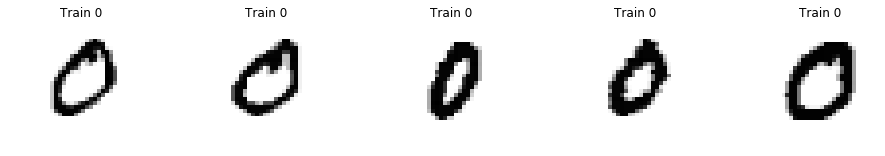

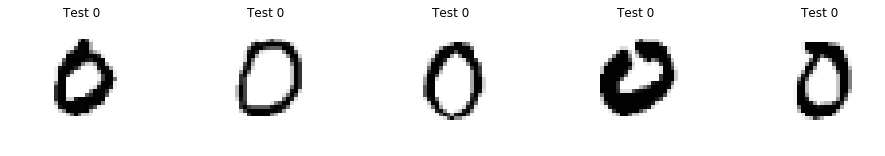

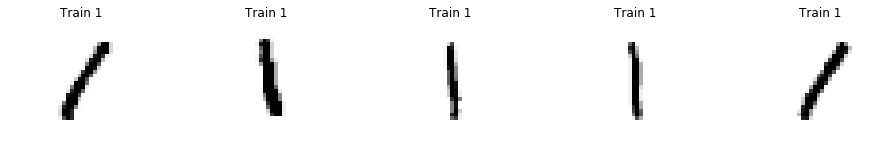

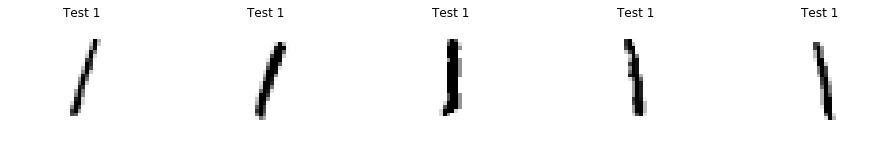

In [5]:
dataset_train,dataset_test,dataset_train_flat_X,dataset_train_flat_Y,dataset_test_flat_X,dataset_test_flat_Y = buildDataSet()
print("Checking shapes for class 0 (train) : ",dataset_train[0].shape)
print("Checking shapes for class 0 (test) : ",dataset_test[0].shape)
print("Checking first samples")
for i in range(2):
    DrawPics(dataset_train[i],5,template='Train {}',classnumber=i)
    DrawPics(dataset_test[i],5,template='Test {}',classnumber=i)

### Build Neural Network for computing triplet similarity

In [6]:
def build_network(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''

    # Convolutional Neural Network
    network = Sequential()
    network.add(Conv2D(128, (7,7), activation='relu',padding='same',
                     input_shape=input_shape,
                     kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform',padding='same',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Conv2D(256, (3,3), activation='relu', kernel_initializer='he_uniform',padding='same',
                     kernel_regularizer=l2(2e-4)))
    network.add(Flatten())
    network.add(Dense(4096, activation='relu',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    
    network.add(Dense(embeddingsize, activation=None,
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))
    
    return network

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
def build_model3(input_shape, network, margin=0.2):
    '''
    Define the Keras Model for training 
        Input : 
            input_shape : shape of input images
            network : Neural network to train outputing embeddings
            margin : minimal distance between Anchor-Positive and Anchor-Negative for the lossfunction (alpha)
    
    '''
     # Define the tensors for the three input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input") 
    
    # Generate the encodings (feature vectors) for the three images
    encoded_a = network(anchor_input)
    encoded_p = network(positive_input)
    encoded_n = network(negative_input)
    
    #TripletLoss Layer
    loss_layer = TripletLossLayer(alpha=margin,name='3xLoss')([encoded_a,encoded_p,encoded_n])
    
    # Connect the inputs with the outputs
    network_train = Model(inputs=[anchor_input,positive_input,negative_input],outputs=loss_layer)
    
    # return the model
    return network_train



In [7]:
alpha1=1
alpha2=0.5

In [8]:
#modele en 3xloss
network3 = build_network(input_shape,embeddingsize=10)
network3_train = build_model3(input_shape,network3,margin=alpha1)
optimizer3 = Adam(lr = 0.00006)
network3_train.compile(loss=None,optimizer=optimizer3)
network3_train.summary()
plot_model(network3_train,show_shapes=True, show_layer_names=True, to_file=model_path+'model_summary_3x.png')

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 10)           51874442    anchor_input[0][0]               
                                     

![alt text](24 - 3x_vs_4x_mnist/model_summary_3x.png " ")

In [9]:
def build_metric_network(single_embedding_shape):
    '''
    Define the neural network to learn the metric
    Input : 
            single_embedding_shape : shape of input embeddings or feature map. Must be an array
            
    '''
    #compute shape for input
    input_shape = single_embedding_shape
    #the two input embeddings will be concatenated    
    input_shape[0] = input_shape[0]*2
    
     # Neural Network
    network = Sequential(name="learned_metric")
    network.add(Dense(4, activation='relu',
                   input_shape=input_shape, 
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    network.add(Dense(4, activation='relu',                   
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))    
    
    #Last layer : binary softmax
    network.add(Dense(2, activation='softmax'))
    
    #Select only one output value from the softmax
    network.add(Lambda(lambda x: x[:,0]))
    
    return network

    
class QuadrupletLossLayer(Layer):
    def __init__(self, alpha, beta, **kwargs):
        self.alpha = alpha
        self.beta = beta
        self.debugeric = 1
  
        super(QuadrupletLossLayer, self).__init__(**kwargs)
    
    def quadruplet_loss(self, inputs):
        ap_dist,an_dist,nn_dist = inputs
        
        #square
        ap_dist2 = K.square(ap_dist)
        an_dist2 = K.square(an_dist)
        nn_dist2 = K.square(nn_dist)
        
        return K.sum(K.maximum(ap_dist2 - an_dist2 + self.alpha, 0), axis=0) + K.sum(K.maximum(ap_dist2 - nn_dist2 + self.beta, 0), axis=0)
    
    def call(self, inputs):
        loss = self.quadruplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
def build_model4(input_shape, network, metricnetwork,margin=0.1, margin2=0.01):
    '''
    Define the Keras Model for training 
        Input : 
            input_shape : shape of input images
            network : Neural network to train outputing embeddings
            metricnetwork : Neural network to train the learned metric
            margin : minimal distance between Anchor-Positive and Anchor-Negative for the lossfunction (alpha)
    
    '''
     # Define the tensors for the four input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input") 
    negative2_input = Input(input_shape, name="negative2_input")
    
    # Generate the encodings (feature vectors) for the four images
    encoded_a = network(anchor_input)
    encoded_p = network(positive_input)
    encoded_n = network(negative_input)
    encoded_n2 = network(negative2_input)
    
    #compute the concatenated pairs
    encoded_ap = Concatenate(axis=-1,name="Anchor-Positive")([encoded_a,encoded_p])
    encoded_an = Concatenate(axis=-1,name="Anchor-Negative")([encoded_a,encoded_n])
    encoded_nn = Concatenate(axis=-1,name="Negative-Negative2")([encoded_n,encoded_n2])
    
    #compute the distances AP, AN, NN
    ap_dist = metricnetwork(encoded_ap)
    an_dist = metricnetwork(encoded_an)
    nn_dist = metricnetwork(encoded_nn)
    
    #QuadrupletLoss Layer
    loss_layer = QuadrupletLossLayer(alpha=margin,beta=margin2,name='4xLoss')([ap_dist,an_dist,nn_dist])
    
    # Connect the inputs with the outputs
    network_train = Model(inputs=[anchor_input,positive_input,negative_input,negative2_input],outputs=loss_layer)
    
    # return the model
    return network_train

In [10]:
#modele en 4xloss
network4 = build_network(input_shape,embeddingsize=10)
network4.set_weights(network3.get_weights()) #copy weights to have identical networks
metric_network4 = build_metric_network(single_embedding_shape=[10])
network4_train = build_model4(input_shape,network4,metric_network4,margin=alpha1, margin2=alpha2)
optimizer4 = Adam(lr = 0.00006)
network4_train.compile(loss=None,optimizer=optimizer4)
network4_train.summary()
plot_model(network4_train,show_shapes=True, show_layer_names=True, to_file=model_path+'model_summary_4x.png')

n_iteration=0

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
negative2_input (InputLayer)    (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential

![alt text](25_mnist_10/model_summary_4x.png " ")

In [11]:
#testing our NN with dummy image
featured_img = network4.predict(np.ones((1,img_rows,img_cols,1)))
print(featured_img)

[[ 0.17941257 -0.5890693   0.18798093 -0.00266283 -0.01744844 -0.11041978
   0.1995618   0.57350296  0.44022048 -0.10219106]]


### Preparing batch for training


In [12]:
def get_batch_random(batch_size,s="train"):
    """
    Create batch of APN quadruplets with a complete random strategy
    
    Arguments:
    batch_size -- integer 

    Returns:
    quadruplets -- list containing 4 tensors A,P,N,N2 of shape (batch_size,w,h,c)
    """
    if s == 'train':
        X = dataset_train
    else:
        X = dataset_test

    m, w, h,c = X[0].shape
    
    
    # initialize result
    quadruplets=[np.zeros((batch_size,h, w,c)) for i in range(4)]
    
    for i in range(batch_size):
        #Pick one random class for anchor
        anchor_class = np.random.randint(0, nb_classes)
        nb_sample_available_for_class_AP = X[anchor_class].shape[0]
        
        #Pick two different random pics for this class => A and P
        [idx_A,idx_P] = np.random.choice(nb_sample_available_for_class_AP,size=2,replace=False)
        
        #Pick another class for N, different from anchor_class
        negative_class = (anchor_class + np.random.randint(1,nb_classes)) % nb_classes
        nb_sample_available_for_class_N = X[negative_class].shape[0]
        
        #Pick a random pic for this negative class => N
        idx_N = np.random.randint(0, nb_sample_available_for_class_N)
        
        #Pick another class for N2, different from anchor_class and negative_class
        remainingClasses = np.setdiff1d(range(nb_classes),[anchor_class,negative_class])
        negative2_class = np.random.choice(remainingClasses,1)[0]
        nb_sample_available_for_class_N2 = X[negative2_class].shape[0]
                                        
        #Pick a random pic for this negative class => N2
        idx_N2 = np.random.randint(0, nb_sample_available_for_class_N2)

        quadruplets[0][i,:,:,:] = X[anchor_class][idx_A,:,:,:]
        quadruplets[1][i,:,:,:] = X[anchor_class][idx_P,:,:,:]
        quadruplets[2][i,:,:,:] = X[negative_class][idx_N,:,:,:]
        quadruplets[3][i,:,:,:] = X[negative2_class][idx_N2,:,:,:]

    return quadruplets

def drawQuadriplets(quadripletbatch, nbmax=None):
    """display the four images for each quadriplets in the batch
    """
    labels = ["Anchor", "Positive", "Negative", "Negative2"]

    if (nbmax==None):
        nbrows = quadripletbatch[0].shape[0]
    else:
        nbrows = min(nbmax,quadripletbatch[0].shape[0])
                 
    for row in range(nbrows):
        fig=plt.figure(figsize=(16,2))
    
        for i in range(4):
            subplot = fig.add_subplot(1,4,i+1)
            axis("off")
            plt.imshow(quadripletbatch[i][row,:,:,0],vmin=0, vmax=1,cmap='Greys')
            subplot.title.set_text(labels[i])
            
def get_batch_hard(draw_batch_size,hard_batchs_size,norm_batchs_size,network3, network4, metric_network4, s="train"):
    """
    Create batch of APN "hard" triplets/quadruplets
    
    Arguments:
    draw_batch_size -- integer : number of initial randomly taken samples   
    hard_batchs_size -- interger : select the number of hardest samples to keep
    norm_batchs_size -- interger : number of random samples to add

    Returns:
    triplets -- list containing 3 tensors A,P,N of shape (hard_batchs_size+norm_batchs_size,w,h,c)
    quadruplets -- list containing 4 tensors A,P,N,N2 of shape (hard_batchs_size+norm_batchs_size,w,h,c)
    """
    if s == 'train':
        X = dataset_train
    else:
        X = dataset_test

    m, w, h,c = X[0].shape
    
    
    #Step 1 : pick a random batch to study
    studybatch = get_batch_random(draw_batch_size,s)
    
    #Step 2 : compute the loss with current network : d(A,P)-d(A,N). The alpha parameter here is omited here since we want only to order them
    studybatchloss = np.zeros((draw_batch_size))
    
    #Compute embeddings for anchors, positive and negatives
    A = network3.predict(studybatch[0])
    P = network3.predict(studybatch[1])
    N = network3.predict(studybatch[2])
    
    #Compute d(A,P)-d(A,N)
    studybatchtripletloss = np.sum(np.square(A-P),axis=1) - np.sum(np.square(A-N),axis=1)
    
    #Sort by distance (high distance first) and take hard_batchs_size smaples from it
    selectiontriplet = np.argsort(studybatchtripletloss)[::-1][:hard_batchs_size]
    
    #Draw other random samples from the batch
    selection2triplet = np.random.choice(np.delete(np.arange(draw_batch_size),selectiontriplet),norm_batchs_size,replace=False)
    selectiontriplet = np.append(selectiontriplet,selection2triplet)
    
    triplets = [studybatch[0][selectiontriplet,:,:,:], studybatch[1][selectiontriplet,:,:,:], studybatch[2][selectiontriplet,:,:,:]]
    
    #Compute same with 4xloss
    #========================
    
    #Embeddings
    A = network4.predict(studybatch[0])
    P = network4.predict(studybatch[1])
    N = network4.predict(studybatch[2])
    N2 = network4.predict(studybatch[3])
    
    #compute the concatenated pairs
    encoded_ap = np.concatenate([A,P], axis=-1)
    encoded_an = np.concatenate([A,N], axis=-1)
    encoded_nn = np.concatenate([N,N2], axis=-1)
    
    #compute the distances AP, AN, NN
    ap_dist = metric_network4.predict(encoded_ap)
    an_dist = metric_network4.predict(encoded_an)
    nn_dist = metric_network4.predict(encoded_nn)
    
    #compute d(A,P)-d(A,N) + d(A,P)-d(N,N2)
    studybatchquadrupletloss = 2*ap_dist - an_dist - nn_dist
    
    #Sort by distance
    selectionquadruplet = np.argsort(studybatchquadrupletloss)[::-1][:hard_batchs_size]
    
    #Draw other random samples from the batch
    selection2quadruplet = np.random.choice(np.delete(np.arange(draw_batch_size),selectionquadruplet),norm_batchs_size,replace=False)
    selectionquadruplet = np.append(selectionquadruplet,selection2quadruplet)
    
    quadruplets = [studybatch[0][selectionquadruplet,:,:,:], studybatch[1][selectionquadruplet,:,:,:], studybatch[2][selectionquadruplet,:,:,:],studybatch[3][selectionquadruplet,:,:,:] ]
    
    return triplets,quadruplets

Checking batch width, should be 4 :  4
Shapes in the batch A:(2, 28, 28, 1) P:(2, 28, 28, 1) N:(2, 28, 28, 1) N2:(2, 28, 28, 1)
Shapes in the hardbatch 4x A:(2, 28, 28, 1) P:(2, 28, 28, 1) N:(2, 28, 28, 1)


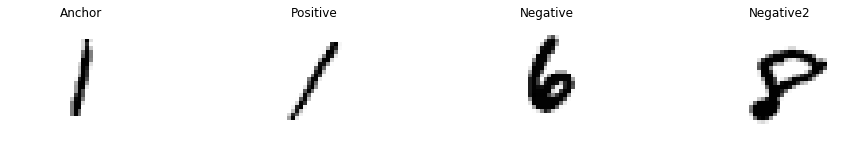

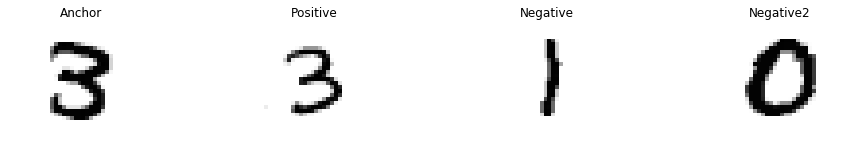

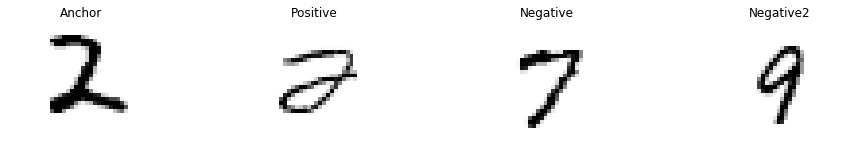

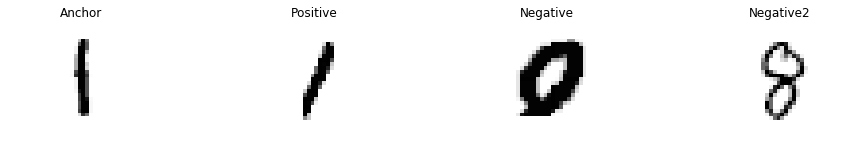

In [13]:
quadruplets = get_batch_random(2)
print("Checking batch width, should be 4 : ",len(quadruplets))
print("Shapes in the batch A:{0} P:{1} N:{2} N2:{3}".format(quadruplets[0].shape, quadruplets[1].shape, quadruplets[2].shape, quadruplets[3].shape))
drawQuadriplets(quadruplets)
hardtriplets,hardquadruplets = get_batch_hard(50,1,1,network3,network4,metric_network4)
print("Shapes in the hardbatch 4x A:{0} P:{1} N:{2}".format(hardquadruplets[0].shape, hardquadruplets[1].shape, hardquadruplets[2].shape, hardquadruplets[3].shape))
drawQuadriplets(hardquadruplets)

### Validation / evaluation



In [14]:
def compute_l2_dist(a,b):
    return np.sum(np.square(a-b))

def compute_learned_dist(a,b,metricnetwork):
    c = np.concatenate((a,b), axis=-1)
    d = np.reshape(c,(1,c.shape[0]))
    return metricnetwork.predict(d)

In [15]:
def compute_probs(network,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                probs[k] = -compute_l2_dist(embeddings[i,:],embeddings[j,:])
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                    #print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs,y

def compute_probs3i(network,metricnetwork,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #print(i)
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                probs[k] = -compute_learned_dist(embeddings[i,:],embeddings[j,:],metricnetwork)
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                    #print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs,y

def compute_probs3iVectorized(network,metricnetwork,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]
    
    #Array to store embeddings pair to be fed into metricnetwork
    embeddingpairs = np.zeros((nbevaluation,size_embedding*2))
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #print(i)
            #Against all other images
            for j in range(i+1,m):
                #store embeddings1
                embeddingpairs[k,:size_embedding] = embeddings[i,:]
                #store embeddings2
                embeddingpairs[k,size_embedding:] = embeddings[j,:]
                
                #compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                if (Y[i]==Y[j]):
                    y[k] = 1
                else:
                    y[k] = 0
                k += 1
    
    #Take inverted distance as probabilities
    probs = metricnetwork.predict(embeddingpairs) * -1
    return probs,y


def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds,auc

def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (nb_classes,nb_classes) 
    '''
    res = np.zeros((nb_classes,nb_classes))
    
    ref_images = np.zeros((nb_classes,img_rows,img_cols,1))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
        ref_images[i,:,:,:] = dataset_test[i][0,:,:,:]
    ref_embeddings = network.predict(ref_images)
    
    for i in range(nb_classes):
        for j in range(nb_classes):
            res[i,j] = compute_l2_dist(ref_embeddings[i],ref_embeddings[j])
    return res

def draw_interdist(network,n_iteration):
    interdist = compute_interdist(network)
    
    data = []
    for i in range(nb_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} iterations'.format(n_iteration))
    ax.set_ylim([0,3])
    plt.xlabel('Classes')
    plt.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(nb_classes))

    plt.show()
    
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
    
def draw_roc(fpr, tpr,thresholds,auc,n_iteration):
    #find threshold
    targetfpr=1e-3
    _, idx = find_nearest(fpr,targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f} @ {4} iterations\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold),n_iteration ))
    # show the plot
    plt.show()
    
def draw_roc_dual(fpr1, tpr1,thresholds1,auc1,fpr2, tpr2,thresholds2,auc2,n_iteration, name1, name2, savewandb=False):
    #find threshold
    targetfpr=1e-3
    _, idx1 = find_nearest(fpr1,targetfpr)
    threshold1 = thresholds1[idx1]
    recall1 = tpr1[idx1]
    _, idx2 = find_nearest(fpr2,targetfpr)
    threshold2 = thresholds2[idx2]
    recall2 = tpr2[idx2]
    
    fig=plt.figure(figsize=(16,6))
    
    subplot = fig.add_subplot(1,2,1)   
    # plot no skill
    subplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    subplot.plot(fpr1, tpr1, marker='.')
    subplot.title.set_text('{5}\nAUC: {0:.3f} @ {4} iterations\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc1,targetfpr,recall1,abs(threshold1),n_iteration,name1 ))
    
    subplot = fig.add_subplot(1,2,2)   
    # plot no skill
    subplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    subplot.plot(fpr2, tpr2, marker='.')
    subplot.title.set_text('{5}\nAUC: {0:.3f} @ {4} iterations\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc2,targetfpr,recall2,abs(threshold2),n_iteration,name2 ))
    
    # show the plot
    fig.show()
    
    if savewandb:
        wandb.log({"Evaluation @ {0} iterations".format(n_iteration):wandb.Image(fig)})
    
def draw_embeddings(network):
    basepredict = network.predict(basepicture)
    plt.scatter(basepredict[:,0],basepredict[:,1])
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    for i in range(4):
        plt.annotate(i, (basepredict[i,0], basepredict[i,1]))

    for i in range(4):
        preds = network.predict(dataset_test[i])
        plt.scatter(preds[:,0],preds[:,1])
        
def draw_embeddings_dual(network1, network2, savewandb=False):
    fig = plt.figure(figsize=(16,6))
    
    subplot = fig.add_subplot(1,2,1)   
    subplot.set_xlim([-11, 11])
    subplot.set_ylim([-11, 11])

    for i in range(nb_classes):
        preds = network1.predict(dataset_test[i])
        subplot.scatter((i+1)*preds[:,0],(i+1)*preds[:,1])
        
    subplot = fig.add_subplot(1,2,2)   
    subplot.set_xlim([-11, 11])
    subplot.set_ylim([-11, 11])

    for i in range(nb_classes):
        preds = network2.predict(dataset_test[i])
        subplot.scatter((i+1)*preds[:,0],(i+1)*preds[:,1])
        
    if savewandb:
        wandb.log({"Embeddings @{0} iterations".format(n_iteration):wandb.Image(fig)})
        
def draw_eval(network,n_iteration):
    probs,yprob = compute_probs(network, metricnetwork,dataset_test_flat_X,dataset_test_flat_Y)
    fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
    draw_roc(fpr, tpr,thresholds,auc,n_iteration)
    draw_embeddings(network)
    draw_interdist(network,n_iteration)
    
def draw_eval_dual(network1,network2,metricnetwork2,n_iteration,savewandb=False):
    #probs1,yprob1 = compute_probs(network1, dataset_test_flat_X[:500,:,:,:],dataset_test_flat_Y[:150])
    #probs2,yprob2 = compute_probs(network2, dataset_test_flat_X[:500,:,:,:],dataset_test_flat_Y[:150])
    probs1,yprob1 = compute_probs(network1, dataset_test_flat_X,dataset_test_flat_Y)
    probs2,yprob2 = compute_probs3iVectorized(network2, metricnetwork2,dataset_test_flat_X,dataset_test_flat_Y)
    fpr1, tpr1, thresholds1,auc1 = compute_metrics(probs1,yprob1)
    fpr2, tpr2, thresholds2,auc2 = compute_metrics(probs2,yprob2)
        
    draw_roc_dual(fpr1, tpr1,thresholds1,auc1,fpr2, tpr2,thresholds2,auc2,n_iteration, "Triplet", "Quadruplet", savewandb)
    #draw_embeddings_dual(network1,network2, savewandb)
    draw_interdist(network1, n_iteration)
    draw_interdist(network2, n_iteration)


In [16]:
#Testing on an untrained network
#draw_eval_dual(network3,network4,metric_network4,n_iteration)

In [17]:
def DrawTestImage(network, images, refidx=0):
    '''
    Evaluate some pictures vs some samples in the test set
        image must be of shape(1,w,h,c)
    
    Returns
        scores : resultat des scores de similarités avec les images de base => (N)
    
    '''
    N=4
    _, w,h,c = dataset_test[0].shape
    nbimages=images.shape[0]
    
    #generates embedings for given images
    image_embedings = network.predict(images)
    
    #generates embedings for reference images
    ref_images = np.zeros((nb_classes,w,h,c))
    for i in range(nb_classes):
        ref_images[i,:,:,:] = dataset_test[i][refidx,:,:,:]
    ref_embedings = network.predict(ref_images)
            
    for i in range(nbimages):
        #Prepare the figure
        fig=plt.figure(figsize=(16,2))
        subplot = fig.add_subplot(1,nb_classes+1,1)
        axis("off")
        plotidx = 2
            
        #Draw this image    
        plt.imshow(images[i,:,:,0],vmin=0, vmax=1,cmap='Greys')
        subplot.title.set_text("Test image")
            
        for ref in range(nb_classes):
            #Compute distance between this images and references
            dist = compute_l2_dist(image_embedings[i,:],ref_embedings[ref,:])
            #Draw
            subplot = fig.add_subplot(1,nb_classes+1,plotidx)
            axis("off")
            plt.imshow(ref_images[ref,:,:,0],vmin=0, vmax=1,cmap='Greys')
            subplot.title.set_text(("Class {0}\n{1:.3e}".format(ref,dist)))
            plotidx += 1
            
def DrawTestImageLearnedMetric(network, metricnetwork, images, refidx=0):
    '''
    Evaluate some pictures vs some samples in the test set
        image must be of shape(1,w,h,c)
    
    Returns
        scores : resultat des scores de similarités avec les images de base => (N)
    
    '''
    N=4
    _, w,h,c = dataset_test[0].shape
    nbimages=images.shape[0]
    
    #generates embedings for given images
    image_embedings = network.predict(images)
    
    #generates embedings for reference images
    ref_images = np.zeros((nb_classes,w,h,c))
    for i in range(nb_classes):
        ref_images[i,:,:,:] = dataset_test[i][refidx,:,:,:]
    ref_embedings = network.predict(ref_images)
            
    for i in range(nbimages):
        #Prepare the figure
        fig=plt.figure(figsize=(16,2))
        subplot = fig.add_subplot(1,nb_classes+1,1)
        axis("off")
        plotidx = 2
            
        #Draw this image    
        plt.imshow(images[i,:,:,0],vmin=0, vmax=1,cmap='Greys')
        subplot.title.set_text("Test image")
            
        for ref in range(nb_classes):
            #Compute distance between this images and references
            dist = compute_learned_dist(image_embedings[i,:],ref_embedings[ref,:],metricnetwork)
            #Draw
            subplot = fig.add_subplot(1,nb_classes+1,plotidx)
            axis("off")
            plt.imshow(ref_images[ref,:,:,0],vmin=0, vmax=1,cmap='Greys')
            subplot.title.set_text(("Class {0}\n{1:0.3}".format(ref,dist[0])))
            plotidx += 1

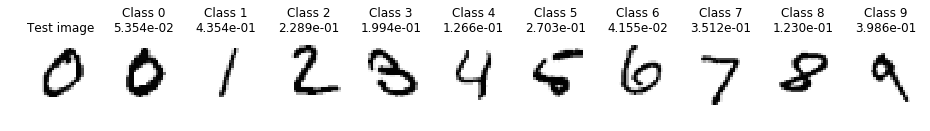

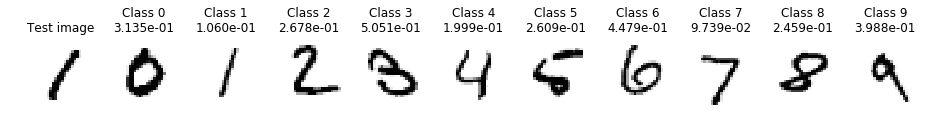

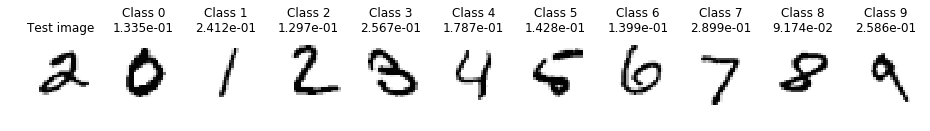

In [18]:
for i in range(3):
    DrawTestImage(network3,np.expand_dims(dataset_train[i][0,:,:,:],axis=0))


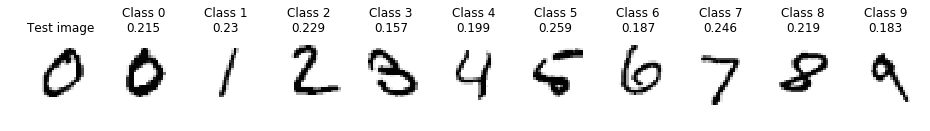

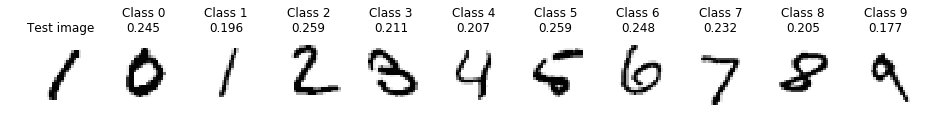

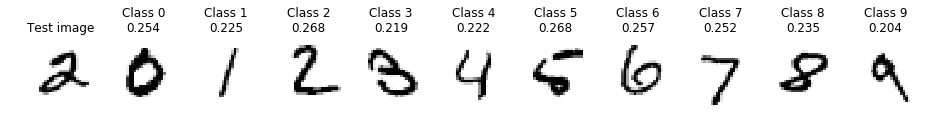

In [19]:
for i in range(3):
    DrawTestImageLearnedMetric(network4,metric_network4,np.expand_dims(dataset_train[i][0,:,:,:],axis=0))

### Training

In [20]:
def reloadFromIteration(n):
    global n_iteration
    n_iteration = n
    network3_train.load_weights('{1}3x-temp_weights_{0:08d}.h5'.format(n_iteration,model_path))
    network4_train.load_weights('{1}4x-temp_weights_{0:08d}.h5'.format(n_iteration,model_path))

In [21]:
# Hyper parameters
evaluate_every = 10000 # interval for evaluating on one-shot tasks
n_iter = 50000 # No. of training iterations
log_every = 100
sample_batch_size = 16

In [22]:
import wandb
wandb.init(project=projectName)
wandb.config.alpha1 = alpha1
wandb.config.alpha2 = alpha2
wandb.config.sample_batch_size = sample_batch_size
wandb.config.learningrate = K.eval(optimizer4.lr) 

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    quadruplets = get_batch_random(sample_batch_size)
    triplets = quadruplets[:3]
    loss1 = network3_train.train_on_batch(triplets, None)
    loss2 = network4_train.train_on_batch(quadruplets, None)
    n_iteration += 1
    if i % log_every == 0:
        None
        wandb.log({'loss3x': loss1,'loss4x': loss2}, step=n_iteration)
    if i % evaluate_every == 0:
        #print("\n ------------- \n")
        elapsed_minutes = (time.time()-t_start)/60.0
        rate = i/elapsed_minutes 
        eta = datetime.now()+timedelta(minutes=(n_iter-i)/rate)
        eta = eta + timedelta(hours=1) #french time
        print("[{4}] iteration {0}: {1:.1f} iter/min, Train Loss: {2} {3}, eta : {5}".format(i, rate,loss1,loss2,n_iteration,eta.strftime("%Y-%m-%d %H:%M:%S") ))
        #network3_train.save_weights('{1}3x-temp_weights_{0:08d}.h5'.format(n_iteration,model_path))
        #network4_train.save_weights('{1}4x-temp_weights_{0:08d}.h5'.format(n_iteration,model_path))      
#Final save
network3_train.save_weights('{1}3x-temp_weights_{0:08d}.h5'.format(n_iteration,model_path))
network4_train.save_weights('{1}4x-temp_weights_{0:08d}.h5'.format(n_iteration,model_path))     
print("Done !")

Starting training process!
-------------------------------------
Instructions for updating:
Use tf.cast instead.


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
requests_with_retry encountered retryable exception: ('Connection aborted.', OSError("(104, 'ECONNRESET')",)). args: ('https://api.wandb.ai/files/crimy/25_mnist_10/3b9e6k1i/file_stream',), kwargs: {'json': {'files': {'wandb-summary.json': {'offset': 0, 'content': ['{"loss4x": 14.63536262512207, "_step": 8100, "loss3x": 1.1578303575515747, "_runtime": 3459.7898831367493, "_timestamp": 1585392092.4442074}\n']}, 'wandb-events.jsonl': {'offset': 76, 'content': ['{"system.gpu.0.powerPercent": 89.65, "system.gpu.0.gpu": 85.13, "system.network.sent": 20071535, "system.gpu.process.0.memoryAllocated": 37.71, "system.gpu.0.memory": 63.73, "system.proc.cpu.threads": 46.0, "_wandb": true, "system.gpu.process.0.gpu": 85.13, "system.disk": 55.3, "system.gpu.process.0.temp": 67.47, "system.gpu.0.temp": 67.47, "system.proc.memory.rssMB": 2588.13, "_runtime": 3482, "system.gpu.process.0.memory": 63.

[10000] iteration 10000: 151.1 iter/min, Train Loss: 1.3319518566131592 15.293403625488281, eta : 2020-03-28 16:14:52


In [ ]:
def DisplayFeatureMaps(network,n, name):
    # retrieve weights from the second hidden layer
    filters, biases = network.layers[0].get_weights()
    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    # plot first few filters
    n_filters, ix = n, 1
    
    for i in range(n_filters):
        # get the filter
        f = filters[:, :, :, i]
        # plot each channel separately
        for j in range(1):
            # specify subplot and turn of axis
            ax = plt.subplot(n_filters, 4, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(f[:, :, j], cmap='gray')
            ix += 1
    # show the figure
    wandb.log({name:plt})
    plt.show()
DisplayFeatureMaps(network3,4, "CNN Filters 3xLoss")
DisplayFeatureMaps(network4,4, "CNN Filters 4xLoss")

In [ ]:
#Full evaluation
draw_eval_dual(network3,network4,metric_network4,n_iteration, savewandb=True)

In [ ]:
draw_eval_dual(network3,network4,metric_network4,n_iteration, savewandb=True)